In [2]:
#Fine Tuning the MobileNetV2

import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

train_dir = 'dataset/train'
validation_dir = 'dataset/valid'
test_dir = 'dataset/test'

# number of classes
num_classes = len(next(os.walk(train_dir))[1])

# check number of samples in train,test,validation directories
num_train_samples = sum([len(files) for r, d, files in os.walk(train_dir) if files])
num_val_samples = sum([len(files) for r, d, files in os.walk(validation_dir) if files])
num_test_samples = sum([len(files) for r, d, files in os.walk(test_dir) if files])

print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of testing samples: {num_test_samples}")

# adjust parameters
batch_size = 26  
epochs = 10

# Calculate steps per epoch
steps_per_epoch = num_train_samples // batch_size
validation_steps = num_val_samples // batch_size

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
                            train_dir, 
                            target_size=(224, 224), 
                            batch_size=24, 
                            class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
                            validation_dir, 
                            target_size=(224, 224), 
                            batch_size=24, 
                            class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
                            test_dir, 
                            target_size=(224, 224), 
                            batch_size=24
    , 
                            class_mode='categorical', 
                            shuffle=False)

# Save the class indices
class_indices = train_generator.class_indices
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



Number of training samples: 2429
Number of validation samples: 774
Number of testing samples: 806
Found 2428 images belonging to 81 classes.
Found 774 images belonging to 81 classes.
Found 806 images belonging to 81 classes.


In [3]:

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=epochs
)

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[:100]:
    layer.trainable = False
    
for layer in base_model.layers[100:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history=model.fit( train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=[early_stopping])




Epoch 1/10
11/93 [==>...........................] - ETA: 1:35 - loss: 4.7560 - accuracy: 0.0682

C:\Users\deepa\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


93/93 [==============================] - 138s 1s/step - loss: 3.5739 - accuracy: 0.2175 - val_loss: 2.1037 - val_accuracy: 0.5029
Epoch 2/10
93/93 [==============================] - 107s 1s/step - loss: 2.1322 - accuracy: 0.4715 - val_loss: 1.3928 - val_accuracy: 0.6667
Epoch 3/10
93/93 [==============================] - 109s 1s/step - loss: 1.6833 - accuracy: 0.5646 - val_loss: 1.1209 - val_accuracy: 0.7184
Epoch 4/10
93/93 [==============================] - 108s 1s/step - loss: 1.4418 - accuracy: 0.6225 - val_loss: 1.0387 - val_accuracy: 0.7414
Epoch 5/10
93/93 [==============================] - 103s 1s/step - loss: 1.2176 - accuracy: 0.6768 - val_loss: 0.8553 - val_accuracy: 0.7802
Epoch 6/10
93/93 [==============================] - 102s 1s/step - loss: 1.0642 - accuracy: 0.7043 - val_loss: 0.7196 - val_accuracy: 0.8276
Epoch 7/10
93/93 [==============================] - 97s 1s/step - loss: 0.9726 - accuracy: 0.7301 - val_loss: 0.7316 - val_accuracy: 0.8132
Epoch 8/10
93/93 [=======

In [4]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc}')

## Save the fine-tuned model
from tensorflow.keras.models import load_model
model.save('fine_tuned1.hdf5')
best_model = load_model('fine_tuned1.hdf5')


34/34 - 24s - loss: 0.5090 - accuracy: 0.8983 - 24s/epoch - 708ms/step
Test accuracy: 0.8982630372047424


C:\Users\deepa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 17s 376ms/step


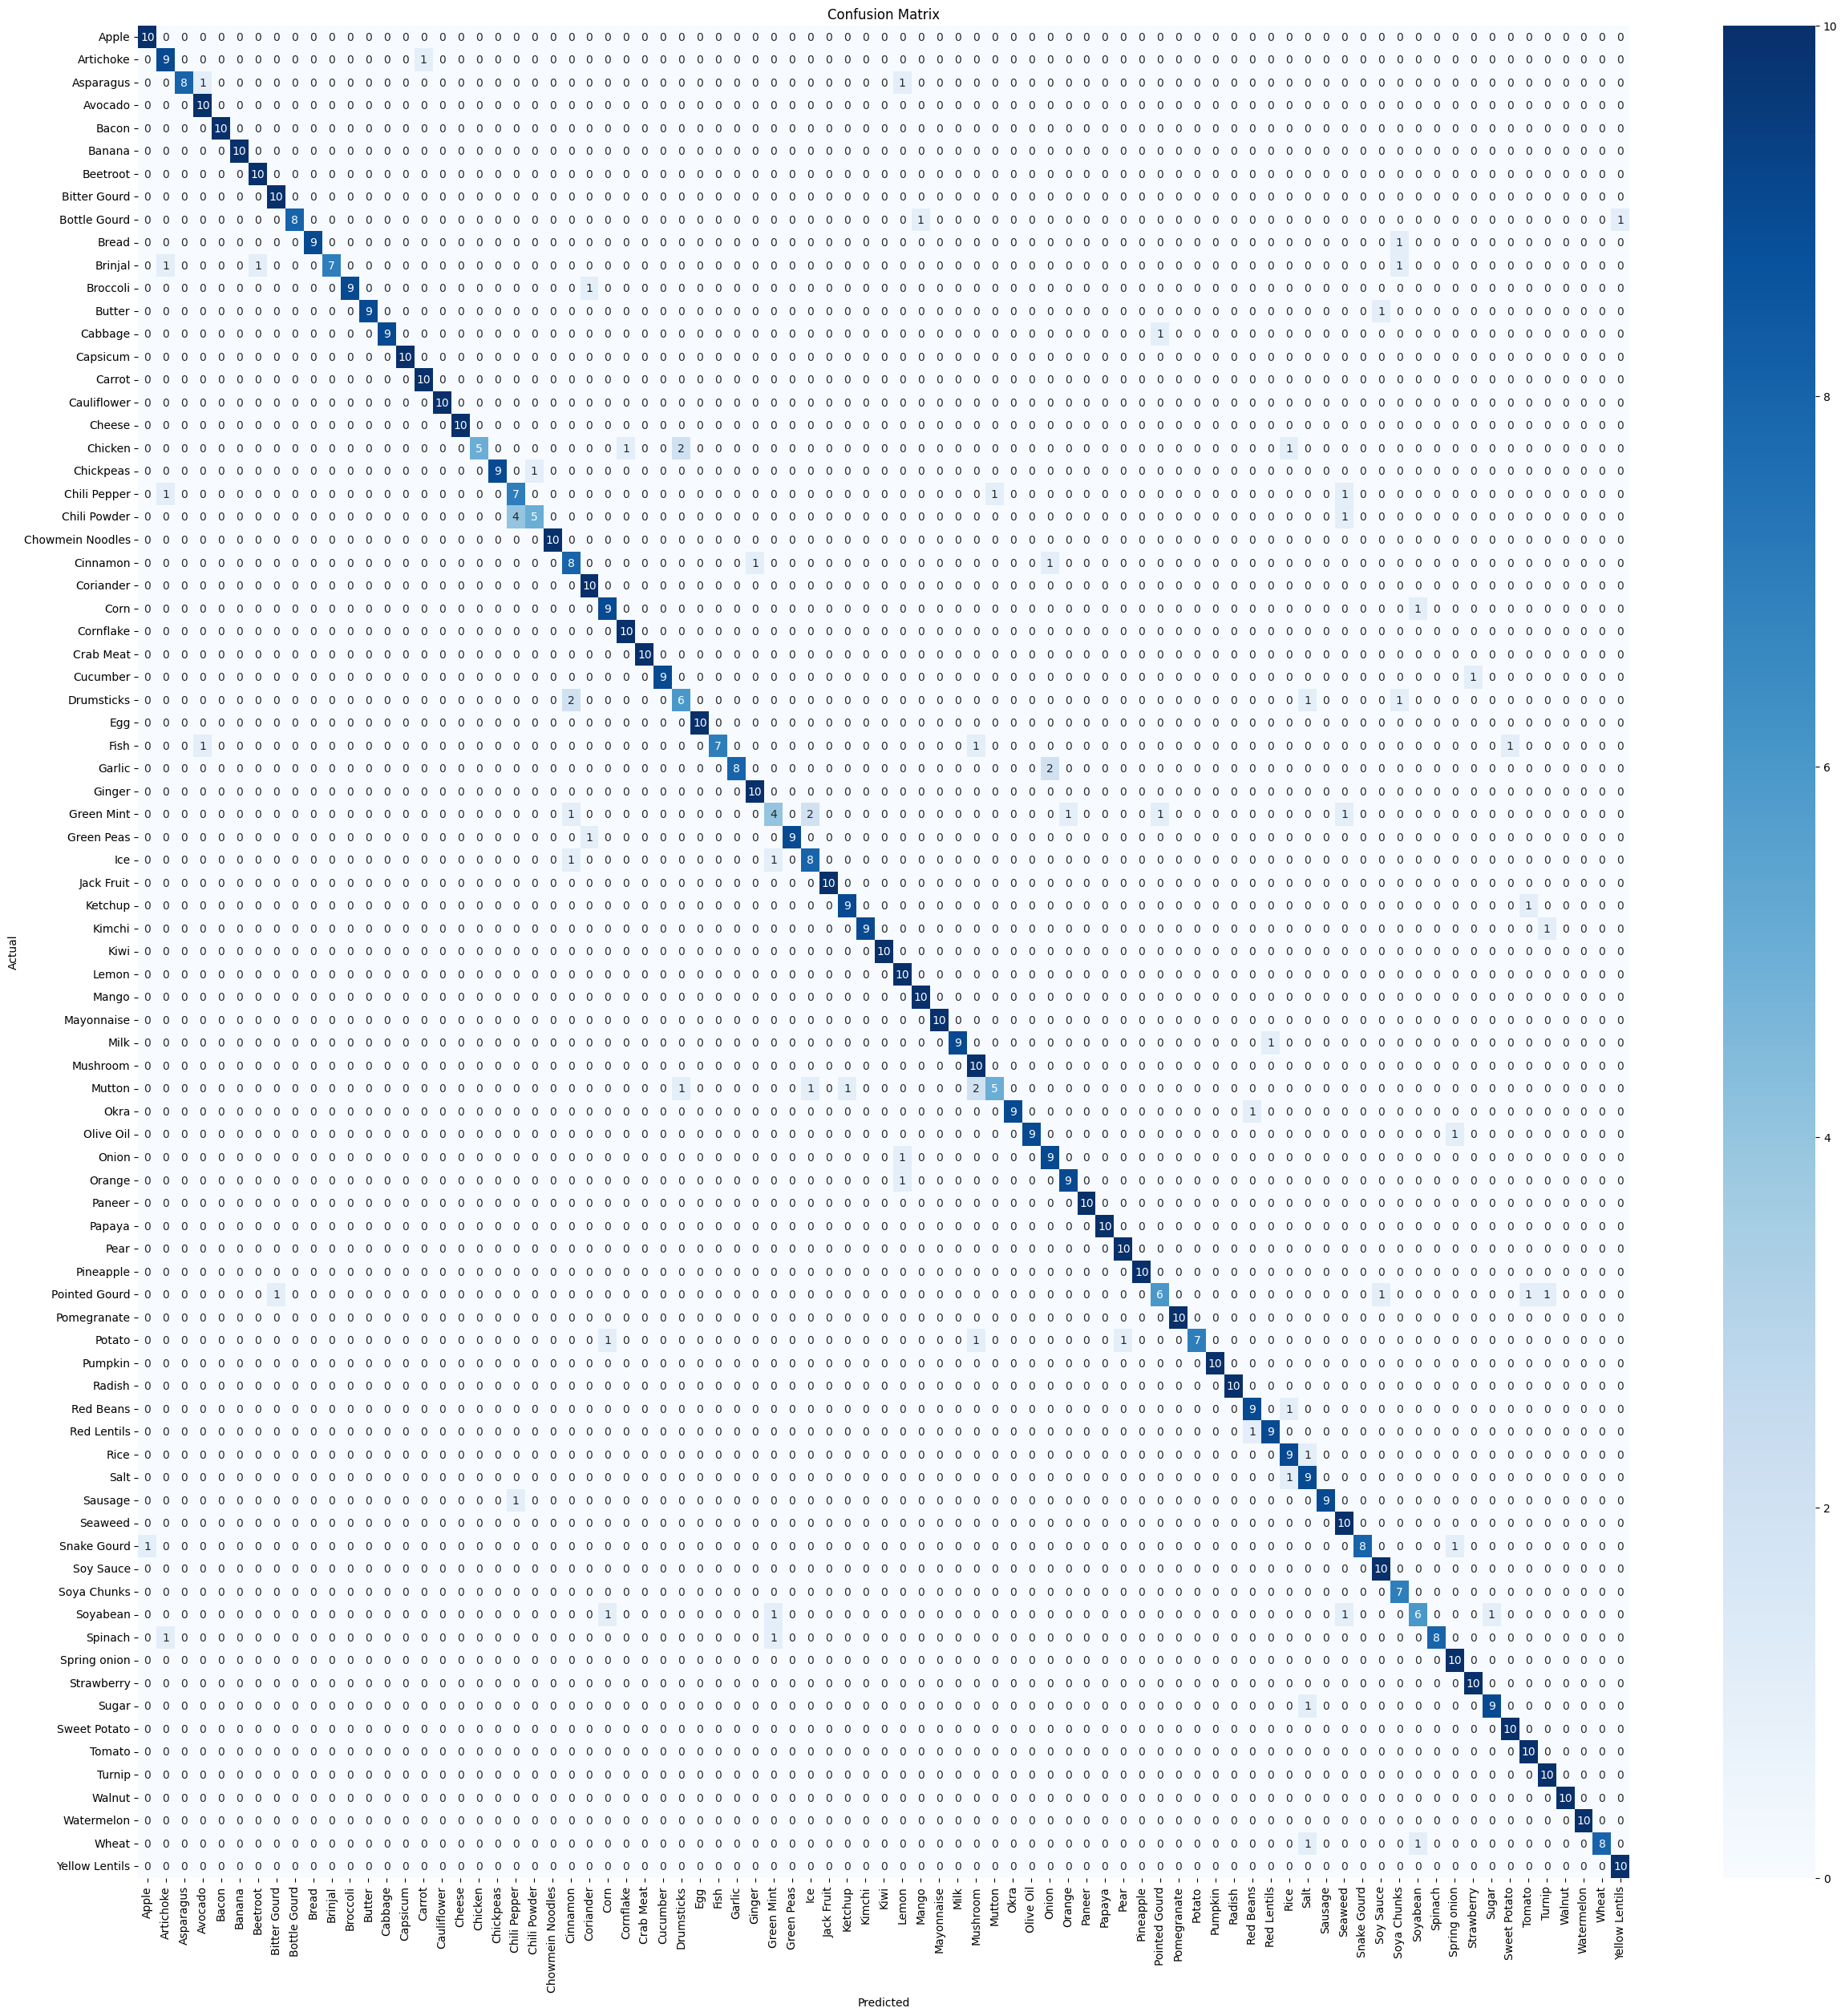

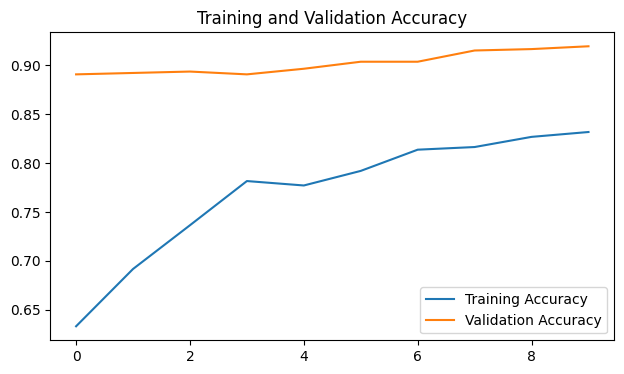

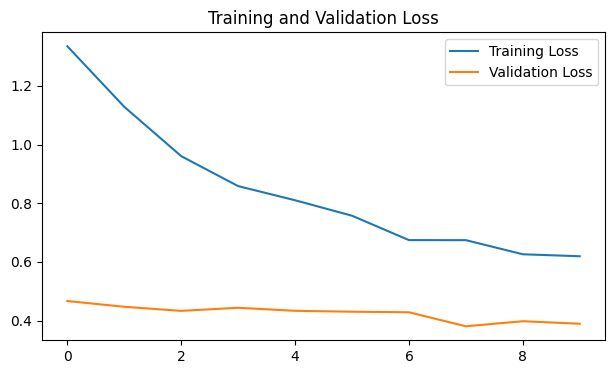

In [5]:

from tensorflow.keras.models import load_model

best_model = load_model('fine_tuned1.hdf5')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
# Generate predictions on the test data
test_generator.reset()  # Make sure the generator is at the start
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# True labels from the test set
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)


import seaborn as sns

# Create a figure with a specific size for the heatmap
plt.figure(figsize=(30, 30))

# Plot a heatmap of the confusion matrix with annotations and integer formatting
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels for the x-axis and y-axis
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Add a title to the plot
plt.title("Confusion Matrix")

# Display the plot
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()